In [17]:
%matplotlib inline

import sys
PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN
from fma_metadata import utils
import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Librosa features - IMBALANCED LEARNING


## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- multi-genre_classification-features

Since in our previous analysis we found out that Decision Tree had higher performances with feature selection, we decided to improve our results starting from those classifiers.

__________________________________
## 2. Multi genre classification
__________________________________
## Import dataset

In [18]:
# When features-anomalyfree is avaiabled

multiclass_dataset = pd.read_csv('/Users/francescogemignani/Desktop/fma-proj/src/Module 1/Anomaly Detection/features_all-feats_outlierfree.csv')
multiclass_dataset.set_index('track_id',inplace=True)
print(f"Librosa features anomaly free: {multiclass_dataset.shape}")
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop','Classical','Jazz']
multiclass_dataset = multiclass_dataset[ multiclass_dataset['genre_top'].isin(genres_subset)]
print(f"Librosa features anomaly free - top 8 genres: {multiclass_dataset.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/francescogemignani/Desktop/fma-proj/src/Module 1/Anomaly Detection/features_all-feats_outlierfree.csv'

In [19]:
#############
# TEMPORARY #
#############

# Import features
multiclass_dataset = utils.load('/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/features.csv')

# Import genre_labels dataset
labels = pd.read_csv('/Users/francescogemignani/Google Drive/DM2/_FMA/bkp/src/Data (cleaned)/genres_top')
labels=labels.set_index('track_id')

# Merging genre_top with librosa
multiclass_dataset = multiclass_dataset.merge(labels, on='track_id')

# drop duplicates
multiclass_dataset.drop_duplicates(keep=False, inplace=True)

# drop NaN
multiclass_dataset.dropna(inplace=True)

# Select top 8 genres
genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop','Classical','Jazz']
multiclass_dataset = multiclass_dataset[multiclass_dataset['genre_top'].isin(genres_subset)]


[]

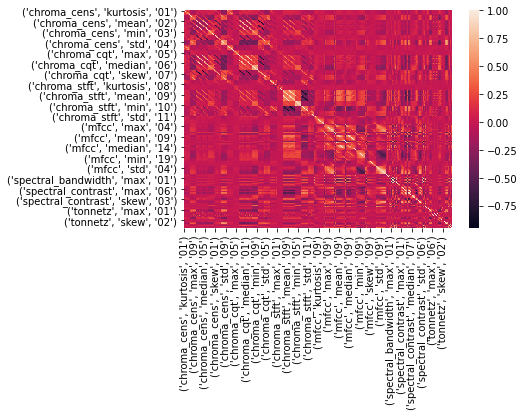

In [20]:
corr = multiclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

In [21]:
# check class distribution in before balancing
pd.concat([multiclass_dataset.genre_top.value_counts(),
                round(multiclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
          axis=1,
          keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,14073,41.40
Electronic,9009,26.50
Hip-Hop,3470,10.21
Folk,2778,8.17
Pop,2324,6.84
Classical,1222,3.59
Jazz,563,1.66
Old-Time / Historic,554,1.63


In [22]:
# class distribution
pd.concat([multiclass_dataset.genre_top.value_counts(),
                round(multiclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
          axis=1,
          keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,14073,41.40
Electronic,9009,26.50
Hip-Hop,3470,10.21
Folk,2778,8.17
Pop,2324,6.84
Classical,1222,3.59
Jazz,563,1.66
Old-Time / Historic,554,1.63


In [23]:
# Data preprocessing

# labels encoding
le = preprocessing.LabelEncoder()
multiclass_dataset['genre_top'] = le.fit_transform(multiclass_dataset['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')

# detach target col
labels = multiclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


In [24]:
# remove labels from dataset
multiclass_dataset.drop('genre_top', axis=1, inplace=True)

In [62]:
# normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(multiclass_dataset)
scaled_features.shape

(33993, 518)

# PCA: Multigenre Classification

## Compute PCA and plot distribution in 2D

In [39]:
# compute PCA using optimal number of components: 154 ( discovered in the notebook mentioned above)
pca = PCA(154,random_state=10)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [40]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=10, stratify=labels)

In [41]:
# development set shape
X.shape, y.shape

((23795, 154), (23795,))

In [42]:
# internal test shape
X_test.shape, y_test.shape

((10198, 154), (10198,))

In [53]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in train test


,counts,percentage (%)
7,9851,41.40
1,6306,26.50
3,2429,10.21
2,1945,8.17
6,1627,6.84
0,855,3.59
4,394,1.66
5,388,1.63


In [54]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in test test')
pd.concat(
    [y_test.value_counts(),
                round(y_test.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in test test


,counts,percentage (%)
7,4222,41.40
1,2703,26.51
3,1041,10.21
2,833,8.17
6,697,6.83
0,367,3.60
4,169,1.66
5,166,1.63


In [55]:
# function for plotting data in 2D with PCA
def pca_2D(X, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = X[:,0]
    df['pca2'] = X[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        data=df,
        palette={'Jazz':'mediumorchid','Rock':'forestgreen', 'Hip-Hop':'dodgerblue',
                 'Pop':'darkorange', 'Electronic':'saddlebrown','Old-Time / Historic':'grey',
                 'Folk':'crimson', 'Classical':'violet'},
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

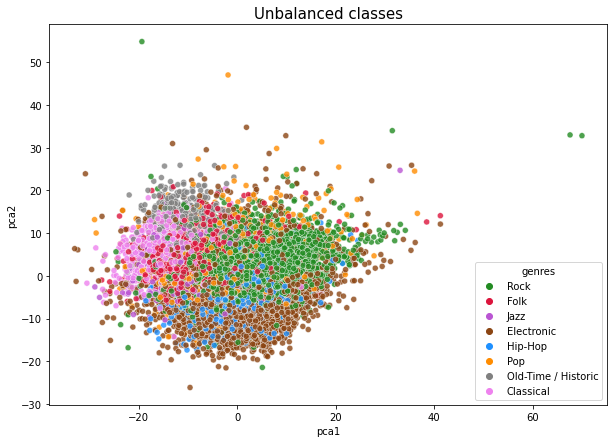

In [56]:
pca_2D(X, y,'Unbalanced classes')

## Imbalanced learning
#### 1) Undersampling - Random

In [63]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [64]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n Class distribution after Random Undersampling")
y_under.value_counts()

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

 Class distribution after Random Undersampling


7    388
5    388
3    388
1    388
6    388
4    388
2    388
0    388
Name: genre_top, dtype: int64

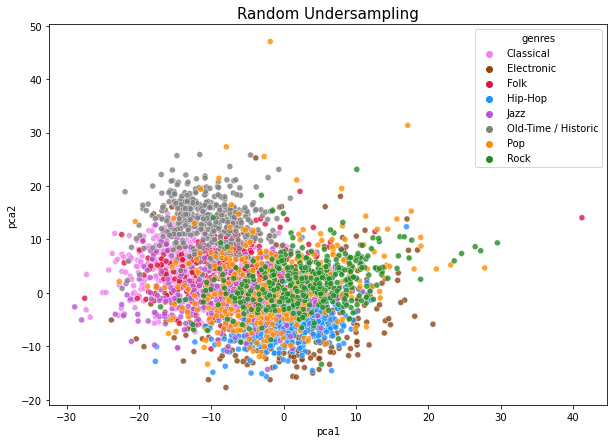

In [65]:
pca_2D(X_under,y_under,'Random Undersampling')

#### 2) Condensed Nearest Neighbor (CNN)

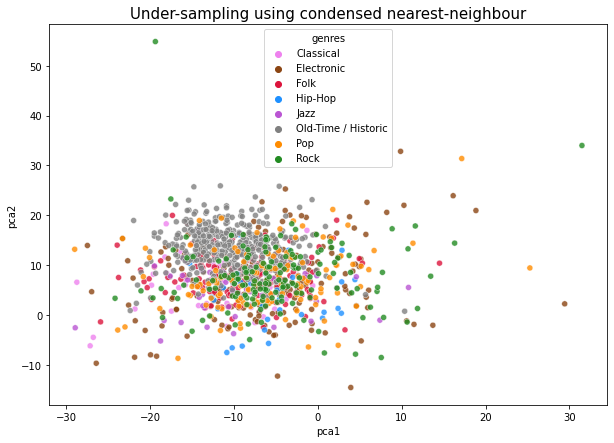

In [66]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### 3) Tomek's Link

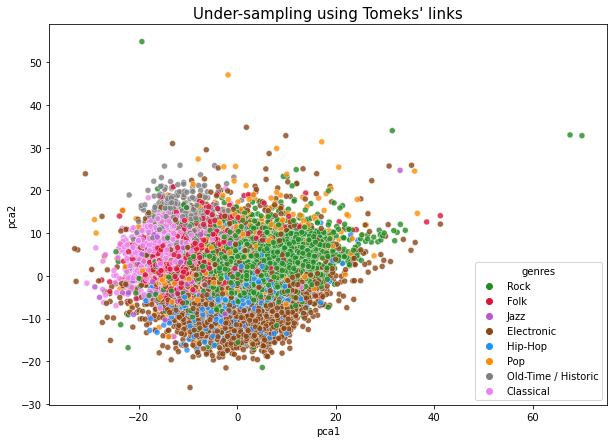

In [67]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [80]:
y_tomek.value_counts()

7    9696
1    6137
3    2340
2    1867
6    1543
0     840
5     388
4     372
Name: genre_top, dtype: int64

#### 4) Oversampling - Random

In [68]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [69]:
X_over.shape, y_over.shape

((33258, 154), (33258,))

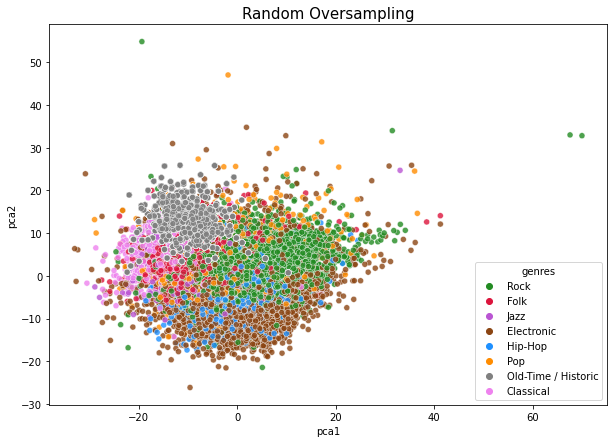

In [70]:
pca_2D(X_over, y_over, 'Random Oversampling')

In [81]:
y_over.value_counts()

7    9851
5    9851
1    6306
3    2429
2    1945
6    1627
0     855
4     394
Name: genre_top, dtype: int64

#### 5) SMOTE

In [71]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((78808, 154), (78808,))

In [72]:
y_smote.value_counts()

7    9851
6    9851
5    9851
4    9851
3    9851
2    9851
1    9851
0    9851
Name: genre_top, dtype: int64

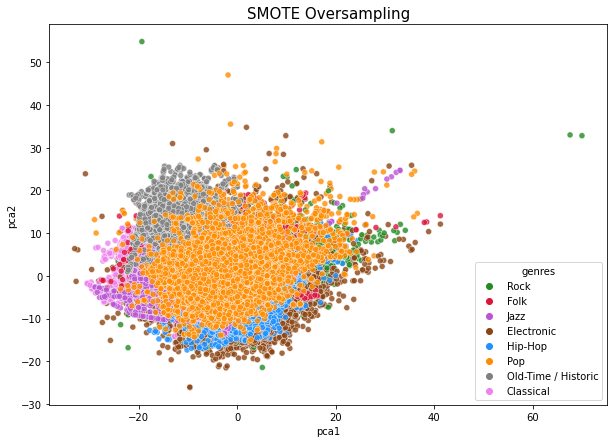

In [73]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### 6) K-Means SMOTE

In [74]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=10, k_neighbors=5)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [75]:
y_ksmote.value_counts()

1    9859
6    9854
3    9854
2    9854
0    9852
7    9851
5    9851
4    9851
Name: genre_top, dtype: int64

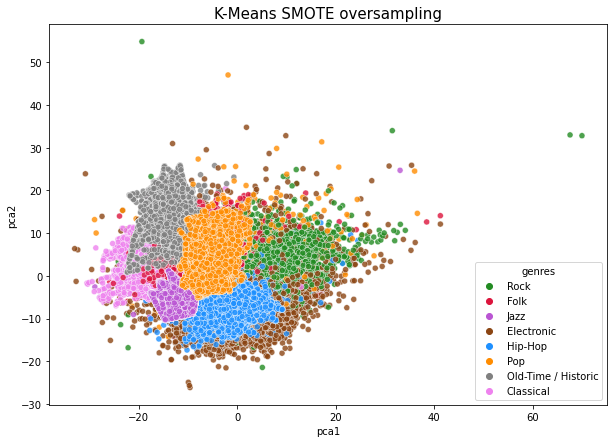

In [76]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### 7) ADASYN

In [77]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [78]:
y_adasyn.value_counts()

2    9986
3    9980
0    9876
6    9856
7    9851
5    9848
4    9805
1    9666
Name: genre_top, dtype: int64

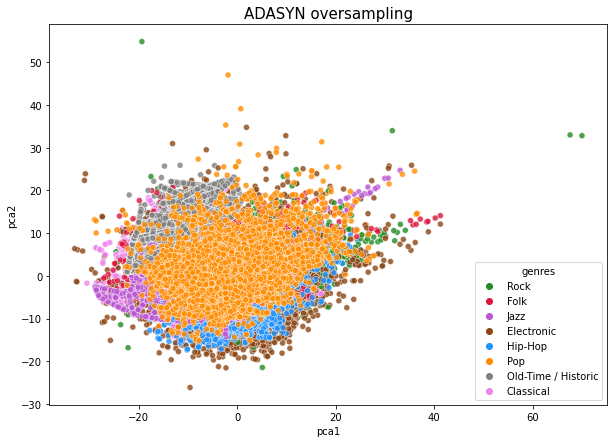

In [79]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

## Decision tree
### Random Search 

In [82]:
from sklearn.model_selection import RandomizedSearchCV

In [94]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(4,50)],
         "min_samples_leaf": [x for x in range(10,55)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=50, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


*******undersampling*******
{'min_samples_split': 10, 'min_samples_leaf': 21, 'max_depth': 8, 'criterion': 'gini'}
accuracy validation: 0.5051483039842086
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   30.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'min_samples_split': 8, 'min_samples_leaf': 45, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.443859649122807
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 17.7min finished


*******Tomek links*******
{'min_samples_split': 23, 'min_samples_leaf': 33, 'max_depth': 8, 'criterion': 'entropy'}
accuracy validation: 0.6187722808791424
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 20.2min finished


*******oversampling*******
{'min_samples_split': 5, 'min_samples_leaf': 16, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.7231644620420223
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 65.0min finished


*******SMOTE*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.6646027800065534
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 67.8min finished


*******K-means SMOTE*******
{'min_samples_split': 25, 'min_samples_leaf': 14, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.7905786124609682
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 72.5min finished


*******ADASYN*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.5358319078900327


###  Retrain Models : Unbalanced vs Balanced

In [103]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 21, min_samples_split=10),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=8,
                                        min_samples_leaf= 21, min_samples_split=10),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 45, min_samples_split=8),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 33, min_samples_split=23),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 16, min_samples_split=5),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 14, min_samples_split=25),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    #y_score = dt.predict_proba(X_test)
    #fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    #roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    #roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    #fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    #save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.6157089625416748
F1-score [0.62912088 0.58549223 0.46358382 0.44590164 0.         0.69798658
 0.03225806 0.74644475]

Recall [0.6239782  0.58527562 0.48139256 0.39193084 0.         0.62650602
 0.01721664 0.83917575]
Precision [0.63434903 0.585709   0.44704571 0.51711027 0.         0.78787879
 0.25531915 0.67216847]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       367
           1       0.59      0.59      0.59      2703
           2       0.45      0.48      0.46       833
           3       0.52      0.39      0.45      1041
           4       0.00      0.00      0.00       169
           5       0.79      0.63      0.70       166
           6       0.26      0.02      0.03       697
           7       0.67      0.84      0.75      4222

    accuracy                           0.62     10198
   macro avg       0.49      0.45      0.45     10198
weighted avg       0.58      0.62      0.5

Text(0.5, 0, '')

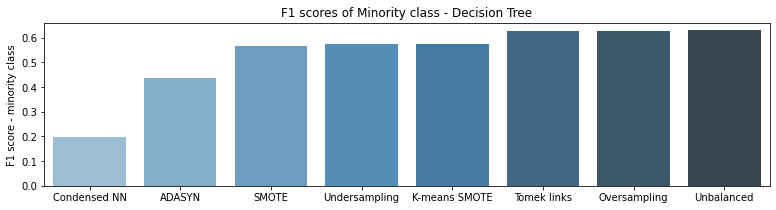

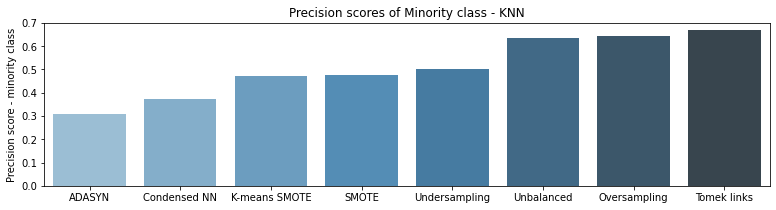

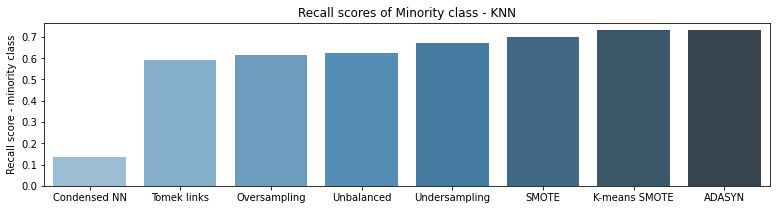

In [105]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN'] #, 'Class Weight']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

# Feature Selection: Multigenre Classification
## Compute Feature Selection and plot distribution in 2D

In [ ]:
# compute feature selection from decision tree model
sfm = SelectFromModel(DecisionTreeClassifier)
X_sfm = sfm.fit_transform(scaled_features)

In [ ]:
print(f"Original number of features: {len(scaled_features.columns)}\nAfter Feature Selector: {X_sfm.shape[1]}\nNumber of Features detached: {scaled_features.shape[1]-X_sfm.shape[1]}")

In [ ]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_sfm, labels, test_size=0.30, random_state=42, stratify=labels)

In [ ]:
# development set shape
X.shape, y.shape

In [ ]:
# internal test shape
X_test.shape, y_test.shape

In [ ]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

In [ ]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in test test')
pd.concat(
    [y_test.value_counts(),
                round(y_test.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

In [ ]:
pca_2D(X, y,'Unbalanced classes')

## Imbalanced learning
#### 1) Undersampling - Random

In [ ]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [ ]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

In [ ]:
pca_2D(X_under,y_under,'Random Undersampling')

#### 2) Condensed Nearest Neighbor (CNN)

In [ ]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

#### 3) Tomek's Link

In [ ]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [ ]:
y_tomek.value_counts()

#### 4) Oversampling - Random

In [ ]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)

In [ ]:
X_over.shape, y_over.shape

In [ ]:
pca_2D(X_over, y_over, 'Random Oversampling')

#### 5) SMOTE

In [ ]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

In [ ]:
y_smote.value_counts()

In [ ]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

#### K-Means SMOTE

In [ ]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5,cluster_balance_threshold=0)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

In [ ]:
y_ksmote.value_counts()

In [ ]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

#### 6) ADASYN

In [ ]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

In [ ]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

## Decision tree
### Random Search 

In [ ]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(4,50)],
         "min_samples_leaf": [x for x in range(10,55)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=50, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

### Retrain Models: Unbalanced vs Balanced

In [ ]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 10, min_samples_split=21),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 38, min_samples_split=25),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=5,
                                        min_samples_leaf= 20, min_samples_split=10),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=5,
                                        min_samples_leaf= 20, min_samples_split=10),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 11, min_samples_split=13),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 10, min_samples_split=26),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=7,
                                        min_samples_leaf= 11, min_samples_split=6),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 20, min_samples_split=36)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

### Confusion Matrices 
#### For each under/over sampling approach

In [ ]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN', 'Class Weight']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

### Compare results
#### Roc Curves

In [ ]:
# plot roc curves
plt.figure(figsize=(7,6))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=3, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=3, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=3, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=3, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=3, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=3, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

NOTE

1.niente StratifiedCV?
2.perche l'undersampling e l oversampling non bilanciano sempre le classi? Anche nella tua binary ho notato che le labels nn vengono sempre ben ripartite


In [48]:
# check partitions
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n***PCA***\nDevelopment set:\n{y.value_counts()}\n\nInternal Test:\
\n{y_test.value_counts()}\n\-----------------")

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

***PCA***
Development set:
7    9851
1    6306
3    2429
2    1945
6    1627
0     855
4     394
5     388
Name: genre_top, dtype: int64

Internal Test:
7    4222
1    2703
3    1041
2     833
6     697
0     367
4     169
5     166
Name: genre_top, dtype: int64
\-----------------
